In [1]:
!git clone https://github.com/Dinith132/steel-industry-energy-consumption.git

fatal: destination path 'steel-industry-energy-consumption' already exists and is not an empty directory.


In [ ]:
cd steel-industry-energy-consumption/wout_down/Training/

/content/steel-industry-energy-consumption/with_down/Training


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
df=pd.read_csv("../data_only_min_max.csv")

In [5]:
df.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Load_Type
0,0.007306,0.049021,0.0,0.0,0.523783,1.0,0.000000,0.0,0.0
1,0.007638,0.054599,0.0,0.0,0.466489,1.0,0.043478,0.0,0.0
2,0.007840,0.057752,0.0,0.0,0.437662,1.0,0.086957,0.0,0.0
3,0.007288,0.056123,0.0,0.0,0.442885,1.0,0.130435,0.0,0.0
4,0.008484,0.061112,0.0,0.0,0.418165,1.0,0.173913,0.0,0.0


In [6]:
# Sliding window transformation
def create_sliding_windows(data, window_size=1):
    X, y = [], []
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size, 1:])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

In [7]:
data={}

In [8]:
df_np = df.to_numpy()

In [ ]:
window_sizes=[1,4,8,16,24,48,64,96,672]

In [10]:
for window in window_sizes:
  X, y = create_sliding_windows(df_np, window)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, shuffle=False)
  data[f"win{window}"] = {
      "X_train": X_train,
      "X_test": X_test,
      "y_train": y_train,
      "y_test": y_test
  }

In [11]:
data['win1']['X_train'].shape, data['win1']['y_train'].shape, data['win1']['X_test'].shape, data['win1']['y_test'].shape

((7182, 1, 8), (7182,), (1577, 1, 8), (1577,))

trainig

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout

In [13]:
def build_lstm_model(model_type, input_shape):
    model = Sequential()

    if model_type == 'single':
        model.add(LSTM(64, input_shape=input_shape))
    elif model_type == 'double':
        model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
        model.add(LSTM(64))
    elif model_type == 'bidirectional':
        model.add(Bidirectional(LSTM(64), input_shape=input_shape))

    model.add(Dropout(0.1))
    model.add(Dense(1))
    return model

In [14]:
import tensorflow.keras.backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

In [15]:
# prompt: mount the disk

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import os
import pickle
from tensorflow.keras.models import load_model

# Save model to disk
def save_model(model, window_size):
    path = f"{model_dir}/win{window_size}.keras"
    model.save(path)

# Load model from disk
def load_saved_model(window_size):
    path = f"{model_dir}/win{window_size}.keras"
    if os.path.exists(path):
        return load_model(path, custom_objects={'rmse': rmse})
    else:
        return None

# Save history to disk
def save_history(history, window_size):
    path = f"{history_dir}/win{window_size}_history.pkl"
    with open(path, 'wb') as f:
        pickle.dump(history.history, f)

# Load history from disk
def load_saved_history(window_size):
    path = f"{history_dir}/win{window_size}_history.pkl"
    if os.path.exists(path):
        with open(path, 'rb') as f:
            return pickle.load(f)
    else:
        return None

Single layer


In [ ]:
# Paths
model_dir = "/content/drive/MyDrive/reserach/wout_down/only_min_max/single/models"
history_dir = "/content/drive/MyDrive/reserach/wout_down/only_min_max/single/history"
os.makedirs(model_dir, exist_ok=True)
os.makedirs(history_dir, exist_ok=True)


In [25]:
single_models = {}

for window_size in window_sizes:
    print(f"==> Window: {window_size}")

    X_train = data[f"win{window_size}"]["X_train"]
    X_test = data[f"win{window_size}"]["X_test"]
    y_train = data[f"win{window_size}"]["y_train"]
    y_test = data[f"win{window_size}"]["y_test"]

    print("-->", X_train.shape, y_train.shape, X_test.shape)

    # Try to load the model
    model = load_saved_model(window_size)
    history_data = load_saved_history(window_size)

    if model is not None and history_data is not None:
        print(f"✅ Loaded model and history for window {window_size}")
        history = None  # Already loaded history_data
    else:
        print(f"🚀 Training new model for window {window_size}")
        model = build_lstm_model('single', (window_size, X_train.shape[2]))
        model.compile(optimizer='adam', loss=rmse, metrics=['mae'])
        history = model.fit(
            X_train, y_train,
            epochs=5,
            batch_size=32,
            validation_split=0.2,
            verbose=1
        )
        save_model(model, window_size)
        save_history(history, window_size)
        history_data = history.history
        print(f"💾 Model and history saved for window {window_size}")

    single_models[f"win{window_size}"] = {
        "model": model,
        "history": history_data  # always a dict
    }


==> Window: 1
--> (7182, 1, 8) (7182,) (1577, 1, 8)
✅ Loaded model and history for window 1
==> Window: 4
--> (7179, 4, 8) (7179,) (1577, 4, 8)
✅ Loaded model and history for window 4
==> Window: 8
--> (7176, 8, 8) (7176,) (1576, 8, 8)
✅ Loaded model and history for window 8
==> Window: 12
--> (7173, 12, 8) (7173,) (1575, 12, 8)
✅ Loaded model and history for window 12


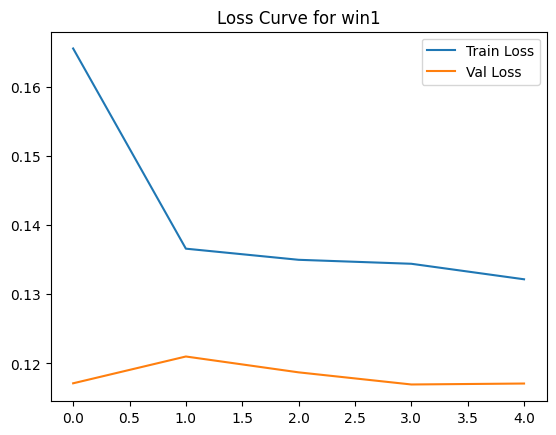

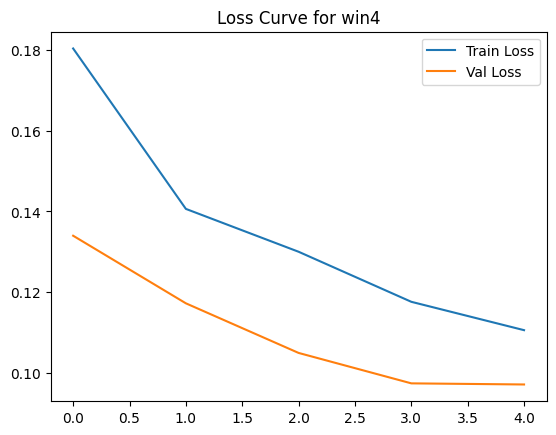

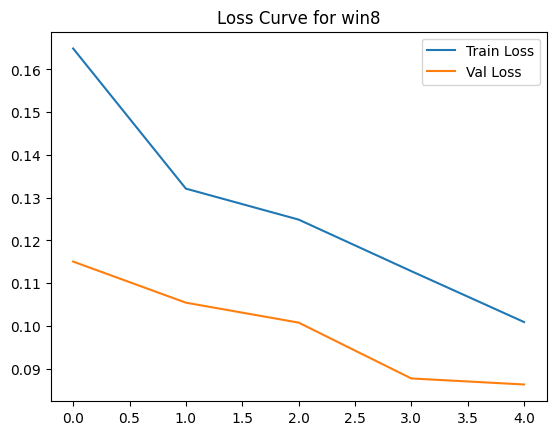

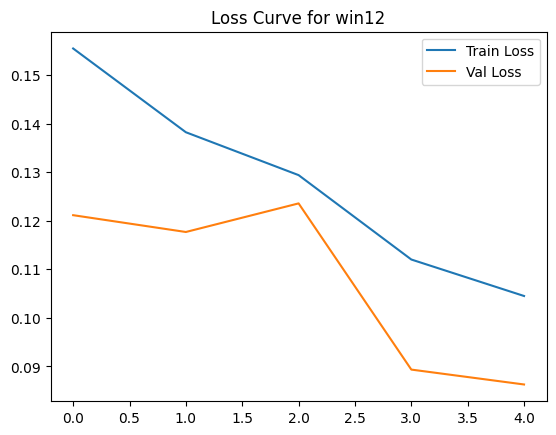

In [26]:
import matplotlib.pyplot as plt

for key, content in single_models.items():
    history_data = content["history"]
    if history_data:
        plt.figure()
        plt.plot(history_data['loss'], label='Train Loss')
        if 'val_loss' in history_data:
            plt.plot(history_data['val_loss'], label='Val Loss')
        plt.title(f"Loss Curve for {key}")
        plt.legend()
        plt.show()


double

In [ ]:
# Paths
model_dir = "/content/drive/MyDrive/reserach/wout_down/only_min_max/double/models"
history_dir = "/content/drive/MyDrive/reserach/wout_down/only_min_max/double/history"
os.makedirs(model_dir, exist_ok=True)
os.makedirs(history_dir, exist_ok=True)

In [21]:
double_models = {}

for window_size in window_sizes:
    print(f"==> Window: {window_size}")

    X_train = data[f"win{window_size}"]["X_train"]
    X_test = data[f"win{window_size}"]["X_test"]
    y_train = data[f"win{window_size}"]["y_train"]
    y_test = data[f"win{window_size}"]["y_test"]

    print("-->", X_train.shape, y_train.shape, X_test.shape)

    # Try to load the model
    model = load_saved_model(window_size)
    history_data = load_saved_history(window_size)

    if model is not None and history_data is not None:
        print(f"✅ Loaded model and history for window {window_size}")
        history = None  # Already loaded history_data
    else:
        print(f"🚀 Training new model for window {window_size}")
        model = build_lstm_model('double', (window_size, X_train.shape[2]))
        model.compile(optimizer='adam', loss=rmse, metrics=['mae'])
        history = model.fit(
            X_train, y_train,
            epochs=5,
            batch_size=32,
            validation_split=0.2,
            verbose=1
        )
        save_model(model, window_size)
        save_history(history, window_size)
        history_data = history.history
        print(f"💾 Model and history saved for window {window_size}")

    double_models[f"win{window_size}"] = {
        "model": model,
        "history": history_data  # always a dict
    }


==> Window: 1
--> (7182, 1, 8) (7182,) (1577, 1, 8)
✅ Loaded model and history for window 1
==> Window: 4
--> (7179, 4, 8) (7179,) (1577, 4, 8)
✅ Loaded model and history for window 4
==> Window: 8
--> (7176, 8, 8) (7176,) (1576, 8, 8)
✅ Loaded model and history for window 8
==> Window: 12
--> (7173, 12, 8) (7173,) (1575, 12, 8)
✅ Loaded model and history for window 12


bi dir

In [ ]:
# Paths
model_dir = "/content/drive/MyDrive/reserach/wout_down/only_min_max/bidir/models"
history_dir = "/content/drive/MyDrive/reserach/wout_down/only_min_max/bidir/history"
os.makedirs(model_dir, exist_ok=True)
os.makedirs(history_dir, exist_ok=True)

In [23]:
bidir_models = {}

for window_size in window_sizes:
    print(f"==> Window: {window_size}")

    X_train = data[f"win{window_size}"]["X_train"]
    X_test = data[f"win{window_size}"]["X_test"]
    y_train = data[f"win{window_size}"]["y_train"]
    y_test = data[f"win{window_size}"]["y_test"]

    print("-->", X_train.shape, y_train.shape, X_test.shape)

    # Try to load the model
    model = load_saved_model(window_size)
    history_data = load_saved_history(window_size)

    if model is not None and history_data is not None:
        print(f"✅ Loaded model and history for window {window_size}")
        history = None  # Already loaded history_data
    else:
        print(f"🚀 Training new model for window {window_size}")
        model = build_lstm_model('bidirectional', (window_size, X_train.shape[2]))
        model.compile(optimizer='adam', loss=rmse, metrics=['mae'])
        history = model.fit(
            X_train, y_train,
            epochs=5,
            batch_size=32,
            validation_split=0.2,
            verbose=1
        )
        save_model(model, window_size)
        save_history(history, window_size)
        history_data = history.history
        print(f"💾 Model and history saved for window {window_size}")

    bidir_models[f"win{window_size}"] = {
        "model": model,
        "history": history_data  # always a dict
    }


==> Window: 1
--> (7182, 1, 8) (7182,) (1577, 1, 8)
✅ Loaded model and history for window 1
==> Window: 4
--> (7179, 4, 8) (7179,) (1577, 4, 8)
✅ Loaded model and history for window 4
==> Window: 8
--> (7176, 8, 8) (7176,) (1576, 8, 8)
✅ Loaded model and history for window 8
==> Window: 12
--> (7173, 12, 8) (7173,) (1575, 12, 8)
✅ Loaded model and history for window 12
